# 3-4 bits/cell allocations

In [11]:
# Import libraries
import json
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import helper
from copy import deepcopy
from itertools import product

In [2]:
# Load retention time data
tdata = pd.read_csv("../data/retention/retention.min.csv.gz")

# Time point
timept = 10000

In [3]:
# Get PBA allocations
pba_allocations_bpc = {3: set(), 4: set()}

# Sweep gamma over some range
for gamma in [0.08204, 0.29155]:
    print("gamma =", gamma)
    lvlcands = {}
    for (lower, upper), d in tdata[tdata["timept"] == timept].groupby(["lower","upper"]):
        lvlcand = d.mean()[["timept","lower","upper","width","successes","failures","reads","sets","resets","cycles","read_bits","set_bits","reset_bits","lvl","time"]].to_dict()
        lvl, cdf = sorted(d["lvl"].values), np.linspace(0.5/len(d), 1-0.5/len(d), len(d)) # symmetric percentile CDF (https://math.stackexchange.com/questions/33488/how-to-calculate-percentile-is-it-possible-to-get-100-percentile)
        lvlcand["lvl"] = np.array(lvl)
        lvlcand["cdf"] = cdf
        try:
            # lvlcand["lower_rd"] = int(np.floor(helper.intersection(np.array([0,64]), np.array([gamma,gamma]), np.array(lvl), cdf)[0][0]))
            # lvlcand["upper_rd"] = int(np.ceil(helper.intersection(np.array([0,64]), np.array([1-gamma,1-gamma]), np.array(lvl), cdf)[0][0]))
            lvlcand["lower_rd"] = helper.intersection(np.array([0,64]), np.array([gamma,gamma]), np.array(lvl), cdf)[0][0]
            lvlcand["upper_rd"] = helper.intersection(np.array([0,64]), np.array([1-gamma,1-gamma]), np.array(lvl), cdf)[0][0]
        except IndexError:
            lvlcand["lower_rd"] = min(lvl)
            lvlcand["upper_rd"] = max(lvl)
        lvlcands[(int(lower), int(upper))] = lvlcand

    pba_allocations = []
    cur_upper = -1
    cands = [lvlcand for lvlcand in lvlcands.values() if lvlcand["lower"] == 0]
    while cands != []:
        next_cur_upper = min([cand["upper_rd"] for cand in cands])
        pba_allocations.append([(int(cand["lower"]), int(cand["upper"])) for cand in cands if cand["upper_rd"] == next_cur_upper])
        cur_upper = next_cur_upper
        cands = [lvlcand for lvlcand in lvlcands.values() if lvlcand["lower_rd"] > cur_upper]
    print(len(pba_allocations), pba_allocations)
    if len(pba_allocations) >= 8 and len(pba_allocations_bpc[3]) == 0:
        print(gamma)
        pba_allocations_bpc[3].update(product(*pba_allocations[:8]))
    if len(pba_allocations) >= 16 and len(pba_allocations_bpc[4]) == 0:
        print(gamma)
        pba_allocations_bpc[4].update(product(*pba_allocations[:16]))
pba_allocations_bpc

gamma = 0.08204
8 [[(0, 9)], [(20, 24)], [(31, 32)], [(40, 41)], [(46, 47)], [(51, 52)], [(56, 57), (56, 58)], [(60, 61)]]
0.08204
gamma = 0.29155
16 [[(0, 8), (0, 9)], [(0, 13), (2, 13), (2, 14), (3, 13), (4, 14), (5, 13), (6, 14), (7, 14), (8, 14), (9, 13), (9, 14), (9, 15), (11, 13), (11, 14), (12, 14)], [(14, 23), (15, 23), (15, 24), (16, 22), (16, 23), (17, 22), (17, 23), (18, 19), (18, 20), (18, 21), (18, 22)], [(23, 24)], [(27, 28)], [(31, 32)], [(35, 36)], [(38, 39)], [(41, 42)], [(44, 45)], [(47, 48), (47, 49)], [(49, 52), (49, 53), (50, 51), (50, 52)], [(52, 55), (52, 56), (53, 54), (53, 55)], [(55, 56), (55, 57)], [(57, 58), (57, 59)], [(59, 60), (59, 61)]]
0.29155


{3: {((0, 9),
   (20, 24),
   (31, 32),
   (40, 41),
   (46, 47),
   (51, 52),
   (56, 57),
   (60, 61)),
  ((0, 9),
   (20, 24),
   (31, 32),
   (40, 41),
   (46, 47),
   (51, 52),
   (56, 58),
   (60, 61))},
 4: {((0, 8),
   (7, 14),
   (16, 22),
   (23, 24),
   (27, 28),
   (31, 32),
   (35, 36),
   (38, 39),
   (41, 42),
   (44, 45),
   (47, 48),
   (50, 51),
   (53, 54),
   (55, 56),
   (57, 58),
   (59, 61)),
  ((0, 8),
   (5, 13),
   (16, 23),
   (23, 24),
   (27, 28),
   (31, 32),
   (35, 36),
   (38, 39),
   (41, 42),
   (44, 45),
   (47, 48),
   (50, 51),
   (53, 55),
   (55, 56),
   (57, 58),
   (59, 61)),
  ((0, 8),
   (9, 15),
   (16, 23),
   (23, 24),
   (27, 28),
   (31, 32),
   (35, 36),
   (38, 39),
   (41, 42),
   (44, 45),
   (47, 49),
   (50, 51),
   (52, 55),
   (55, 57),
   (57, 59),
   (59, 61)),
  ((0, 9),
   (9, 15),
   (17, 22),
   (23, 24),
   (27, 28),
   (31, 32),
   (35, 36),
   (38, 39),
   (41, 42),
   (44, 45),
   (47, 49),
   (49, 52),
   (52, 56),
   

In [4]:
# Digraph
DG = nx.DiGraph()
DG.add_nodes_from(lvlcands.items())
DG.add_edges_from([(cand1, cand2) for cand1 in lvlcands for cand2 in lvlcands if lvlcands[cand2]["lower_rd"] > lvlcands[cand1]["upper_rd"]])
DG.number_of_nodes(), DG.number_of_edges()

(2013, 1052733)

In [5]:
# Get all 3-4 bpc allocations
{k : len(v) for k, v in pba_allocations_bpc.items()}

{3: 2, 4: 84480}

In [6]:
# Plot BW-BER tradeoff in level allocations
results = []
for bpc in range(3, 5):
    for i, a in enumerate(pba_allocations_bpc[bpc]):
        if i % 10 == 0:
            print(bpc, i)

        rdbounds = [0]
        for lvl1, lvl2 in zip(a[:-1], a[1:]):
            cers = []
            for i in range(64):
                if i < lvlcands[lvl1]["lvl"].min():
                    cer1 = 1
                elif i > lvlcands[lvl1]["lvl"].max():
                    cer1 = 0
                else:
                    cer1 = 1 - helper.intersection(lvlcands[lvl1]["lvl"], lvlcands[lvl1]["cdf"], np.array([i, i]), np.array([0, 1]))[1][-1]
                if i < lvlcands[lvl2]["lvl"].min():
                    cer2 = 0
                elif i > lvlcands[lvl2]["lvl"].max():
                    cer2 = 1
                else:
                    cer2 = helper.intersection(lvlcands[lvl2]["lvl"], lvlcands[lvl2]["cdf"], np.array([i, i]), np.array([0, 1]))[1][-1]
                cers.append(cer1 + cer2)
            cers = np.array(cers)
            # print("CERs:", cers)
            # print("Min indices:", np.where(cers == cers.min()))
            # print("Rounded down median min index:", int(np.median(np.where(cers == cers.min()))))
            rdbounds.append(int(np.median(np.where(cers == cers.min()))))
        rdbounds.append(64)

        times, confmat = [], []
        for i, lvl in enumerate(a):
            # Get the relevant data
            lvldata = lvlcands[lvl]

            # Compute average time to target level
            times.append(lvldata["cycles"] * 10e-9)

            # Compute the CER for level
            confvec = []
            for rdbound_low, rdbound_high in zip(rdbounds[:-1], rdbounds[1:]):
                confvec.append(len([l for l in lvldata["lvl"] if (l > rdbound_low) & (l <= rdbound_high)]))
            confmat.append(confvec)
        times, confmat = np.array(times), np.array(confmat)
        
        # Compute overall results
        bw = (48 - np.genfromtxt("../settings/dead_columns.csv", delimiter=",").size) / times.mean() * bpc

        # Symbol error magnitudes
        mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
        rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

        # Function to get Gray code string
        getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

        # Function to get Gray code error rate for each possible symbol confusion
        grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

        # BER
        ber = (grayerr * confmat).sum() / confmat.sum()

        # CER
        cer = 1 - confmat.trace() / confmat.sum()

        # Is a PBA allocation
        is_pba = a in pba_allocations_bpc[bpc]

        # Results
        results.append([bpc, a, rdbounds, confmat, bw, ber, cer, is_pba])

# Get dataframe
data = pd.DataFrame(results, columns=["bpc", "allocation", "read_bounds", "confmat", "bw", "ber", "cer", "is_pba"]).sort_values(["ber", "bw"], ascending=[True, False])
data.to_csv("../data/allocation/allocations34.csv.gz", index=False)
data

3 0
4 0
4 10
4 20
4 30
4 40
4 50
4 60
4 70
4 80
4 90
4 100
4 110
4 120
4 130
4 140
4 150
4 160
4 170
4 180
4 190
4 200
4 210
4 220
4 230
4 240
4 250
4 260
4 270
4 280
4 290
4 300
4 310
4 320
4 330
4 340
4 350
4 360
4 370
4 380
4 390
4 400
4 410
4 420
4 430
4 440
4 450
4 460
4 470
4 480
4 490
4 500
4 510
4 520
4 530
4 540
4 550
4 560
4 570
4 580
4 590
4 600
4 610
4 620
4 630
4 640
4 650
4 660
4 670
4 680
4 690
4 700
4 710
4 720
4 730
4 740
4 750
4 760
4 770
4 780
4 790
4 800
4 810
4 820
4 830
4 840
4 850
4 860
4 870
4 880
4 890
4 900
4 910
4 920
4 930
4 940
4 950
4 960
4 970
4 980
4 990
4 1000
4 1010
4 1020
4 1030
4 1040
4 1050
4 1060
4 1070
4 1080
4 1090
4 1100
4 1110
4 1120
4 1130
4 1140
4 1150
4 1160
4 1170
4 1180
4 1190
4 1200
4 1210
4 1220
4 1230
4 1240
4 1250
4 1260
4 1270
4 1280
4 1290
4 1300
4 1310
4 1320
4 1330
4 1340
4 1350
4 1360
4 1370
4 1380
4 1390
4 1400
4 1410
4 1420
4 1430
4 1440
4 1450
4 1460
4 1470
4 1480
4 1490
4 1500
4 1510
4 1520
4 1530
4 1540
4 1550
4 1560
4 1570
4

,bpc,allocation,read_bounds,confmat,bw,ber,cer,is_pba
1,3,"((0, 9), (20, 24), (31, 32), (40, 41), (46, 47...","[0, 12, 25, 34, 41, 47, 52, 57, 64]","[[1362, 90, 0, 0, 0, 0, 0, 0], [114, 1237, 57,...",480861.792424,0.035462,0.106120,True
0,3,"((0, 9), (20, 24), (31, 32), (40, 41), (46, 47...","[0, 12, 25, 34, 41, 47, 52, 57, 64]","[[1362, 90, 0, 0, 0, 0, 0, 0], [114, 1237, 57,...",490387.150025,0.036287,0.108596,True
49464,4,"((0, 8), (9, 13), (18, 20), (23, 24), (27, 28)...","[0, 9, 13, 18, 24, 27, 31, 35, 38, 41, 44, 47,...","[[983, 369, 88, 11, 1, 0, 0, 0, 0, 0, 0, 0, 0,...",476088.776848,0.114773,0.410856,True
1967,4,"((0, 8), (5, 13), (18, 20), (23, 24), (27, 28)...","[0, 9, 13, 18, 24, 27, 31, 35, 38, 41, 44, 47,...","[[983, 369, 88, 11, 1, 0, 0, 0, 0, 0, 0, 0, 0,...",476376.495918,0.114817,0.410989,True
69523,4,"((0, 8), (3, 13), (18, 20), (23, 24), (27, 28)...","[0, 9, 13, 18, 24, 27, 31, 35, 38, 41, 44, 47,...","[[983, 369, 88, 11, 1, 0, 0, 0, 0, 0, 0, 0, 0,...",476730.611600,0.114828,0.410724,True
...,...,...,...,...,...,...,...,...
55377,4,"((0, 9), (2, 14), (14, 23), (23, 24), (27, 28)...","[0, 10, 13, 19, 24, 27, 31, 35, 38, 41, 44, 47...","[[1144, 258, 48, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",552482.112789,0.131244,0.463989,True
82694,4,"((0, 8), (2, 14), (15, 23), (23, 24), (27, 28)...","[0, 10, 13, 17, 24, 27, 31, 35, 38, 41, 44, 47...","[[1172, 180, 85, 14, 1, 0, 0, 0, 0, 0, 0, 0, 0...",515400.219841,0.131278,0.462710,True
59112,4,"((0, 9), (2, 14), (18, 19), (23, 24), (27, 28)...","[0, 10, 14, 19, 24, 27, 31, 35, 38, 41, 44, 47...","[[1144, 281, 25, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",459841.802269,0.131311,0.462930,True
76459,4,"((0, 8), (2, 14), (18, 19), (23, 24), (27, 28)...","[0, 10, 14, 19, 24, 27, 31, 35, 38, 41, 44, 47...","[[1172, 212, 61, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0,...",433955.767448,0.131410,0.461695,True


In [7]:
# Load allocations
data = pd.read_csv("../data/allocation/allocations34.csv.gz", converters={"allocation": eval, "read_bounds": eval}).drop(columns="confmat")
chosen_allocations = {0: "3.1", 2: "4.1"}
data

,bpc,allocation,read_bounds,bw,ber,cer,is_pba
0,3,"((0, 9), (20, 24), (31, 32), (40, 41), (46, 47...","[0, 12, 25, 34, 41, 47, 52, 57, 64]",480861.792424,0.035462,0.106120,True
1,3,"((0, 9), (20, 24), (31, 32), (40, 41), (46, 47...","[0, 12, 25, 34, 41, 47, 52, 57, 64]",490387.150025,0.036287,0.108596,True
2,4,"((0, 8), (9, 13), (18, 20), (23, 24), (27, 28)...","[0, 9, 13, 18, 24, 27, 31, 35, 38, 41, 44, 47,...",476088.776848,0.114773,0.410856,True
3,4,"((0, 8), (5, 13), (18, 20), (23, 24), (27, 28)...","[0, 9, 13, 18, 24, 27, 31, 35, 38, 41, 44, 47,...",476376.495918,0.114817,0.410989,True
4,4,"((0, 8), (3, 13), (18, 20), (23, 24), (27, 28)...","[0, 9, 13, 18, 24, 27, 31, 35, 38, 41, 44, 47,...",476730.611600,0.114828,0.410724,True
...,...,...,...,...,...,...,...
84477,4,"((0, 9), (2, 14), (14, 23), (23, 24), (27, 28)...","[0, 10, 13, 19, 24, 27, 31, 35, 38, 41, 44, 47...",552482.112789,0.131244,0.463989,True
84478,4,"((0, 8), (2, 14), (15, 23), (23, 24), (27, 28)...","[0, 10, 13, 17, 24, 27, 31, 35, 38, 41, 44, 47...",515400.219841,0.131278,0.462710,True
84479,4,"((0, 9), (2, 14), (18, 19), (23, 24), (27, 28)...","[0, 10, 14, 19, 24, 27, 31, 35, 38, 41, 44, 47...",459841.802269,0.131311,0.462930,True
84480,4,"((0, 8), (2, 14), (18, 19), (23, 24), (27, 28)...","[0, 10, 14, 19, 24, 27, 31, 35, 38, 41, 44, 47...",433955.767448,0.131410,0.461695,True


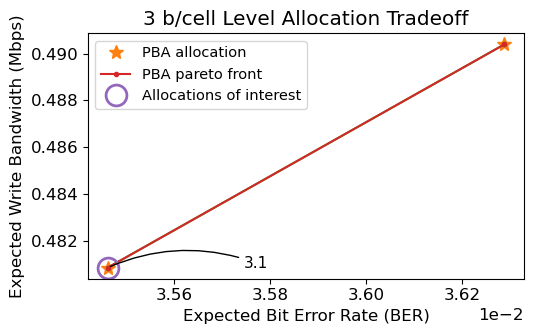

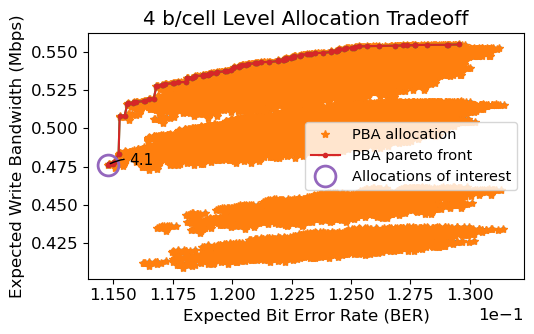

,bpc,allocation,read_bounds,bw,ber,cer,is_pba,bacc
0,3,"((0, 9), (20, 24), (31, 32), (40, 41), (46, 47...","[0, 12, 25, 34, 41, 47, 52, 57, 64]",480861.792424,0.035462,0.106120,True,0.964538
1,3,"((0, 9), (20, 24), (31, 32), (40, 41), (46, 47...","[0, 12, 25, 34, 41, 47, 52, 57, 64]",490387.150025,0.036287,0.108596,True,0.963713
2,4,"((0, 8), (9, 13), (18, 20), (23, 24), (27, 28)...","[0, 9, 13, 18, 24, 27, 31, 35, 38, 41, 44, 47,...",476088.776848,0.114773,0.410856,True,0.885227
3,4,"((0, 8), (5, 13), (18, 20), (23, 24), (27, 28)...","[0, 9, 13, 18, 24, 27, 31, 35, 38, 41, 44, 47,...",476376.495918,0.114817,0.410989,True,0.885183
4,4,"((0, 8), (3, 13), (18, 20), (23, 24), (27, 28)...","[0, 9, 13, 18, 24, 27, 31, 35, 38, 41, 44, 47,...",476730.611600,0.114828,0.410724,True,0.885172
...,...,...,...,...,...,...,...,...
79160,4,"((0, 9), (9, 15), (15, 24), (23, 24), (27, 28)...","[0, 10, 14, 18, 24, 27, 31, 35, 38, 41, 44, 47...",554684.712463,0.127703,0.451059,True,0.872297
81168,4,"((0, 9), (9, 15), (14, 23), (23, 24), (27, 28)...","[0, 10, 14, 19, 24, 27, 31, 35, 38, 41, 44, 47...",554798.465133,0.128188,0.452295,True,0.871812
83303,4,"((0, 9), (9, 15), (14, 23), (23, 24), (27, 28)...","[0, 10, 14, 19, 24, 27, 31, 35, 38, 41, 44, 47...",554813.153308,0.129049,0.454943,True,0.870951
83322,4,"((0, 9), (9, 15), (15, 24), (23, 24), (27, 28)...","[0, 10, 14, 18, 24, 27, 31, 35, 38, 41, 44, 47...",554931.509991,0.129060,0.455031,True,0.870940


In [8]:
# Pareto curve
data["bacc"] = 1 - data["ber"]
best = []
for bpc in range(3, 5):
    plt.figure(figsize=(5.5,3.5))
    # plt.ylim(-0.25, 16.5/bpc - bpc*3/4)
    data_bpc = data[(data["bpc"] == bpc)] #.drop_duplicates(subset=["allocation"])
    data_bpc = data_bpc.sort_values("is_pba",ascending=False,kind="stable").drop_duplicates(subset=["ber", "bw"])

    plt.plot(data_bpc["ber"], data_bpc["bw"] / 1e6, ".") #, label="BWA-PBA allocation")
    plt.plot(data_bpc[data_bpc["is_pba"]]["ber"], data_bpc[data_bpc["is_pba"]]["bw"] / 1e6, "*", markersize=10 if bpc == 3 else None, label="PBA allocation")

    costs = data_bpc[["bacc", "bw"]].values
    unique_costs = data_bpc[["bacc", "bw"]].drop_duplicates().values #
    is_pareto = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_pareto[i] = np.all(np.any(np.delete(costs,i,axis=0)<c, axis=1))
    best.append(data_bpc[is_pareto])
    plt.plot(data_bpc[is_pareto]["ber"], data_bpc[is_pareto]["bw"] / 1e6, '.-') #, label="BWA-PBA pareto front")
    
    pba_data_bpc = data_bpc[data_bpc["is_pba"]]
    pba_costs = pba_data_bpc[["bacc", "bw"]].values
    pba_is_pareto = np.ones(pba_data_bpc.shape[0], dtype = bool)
    for i, c in enumerate(pba_costs):
        pba_is_pareto[i] = np.all(np.any(np.delete(pba_costs,i,axis=0)<c, axis=1))
    best.append(pba_data_bpc[pba_is_pareto & (pba_data_bpc["ber"] == pba_data_bpc["ber"].min())])
    plt.plot(pba_data_bpc[pba_is_pareto]["ber"], pba_data_bpc[pba_is_pareto]["bw"] / 1e6, '.-', label="PBA pareto front")

    evaluate = data_bpc[data_bpc.index.isin(chosen_allocations.keys())]
    plt.plot(evaluate["ber"], evaluate["bw"] / 1e6, "o", label="Allocations of interest", markerfacecolor="none", markeredgewidth=2, markersize=15)
    for i, row in evaluate.iterrows():
        plt.annotate(chosen_allocations[i], (row["ber"], row["bw"] / 1e6), (row["ber"] * 1.008, row["bw"] / 1e6), fontsize=11, arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0.2"))
    
    plt.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
    plt.title(f"{bpc} b/cell Level Allocation Tradeoff")
    plt.xlabel("Expected Bit Error Rate (BER)")
    plt.ylabel("Expected Write Bandwidth (Mbps)")
    plt.legend(fontsize=10.5, loc="best" if bpc == 3 else "right")
    plt.tight_layout()
    plt.savefig(f"figs/{bpc}bpc_pareto.pdf")
    plt.show()
best = pd.concat(best).drop_duplicates(subset=["allocation"])
best

bpc                                                            3
allocation     ((0, 9), (20, 24), (31, 32), (40, 41), (46, 47...
read_bounds                  [0, 12, 25, 34, 41, 47, 52, 57, 64]
bw                                                 480861.792424
ber                                                     0.035462
cer                                                      0.10612
is_pba                                                      True
bacc                                                    0.964538
Name: 0, dtype: object


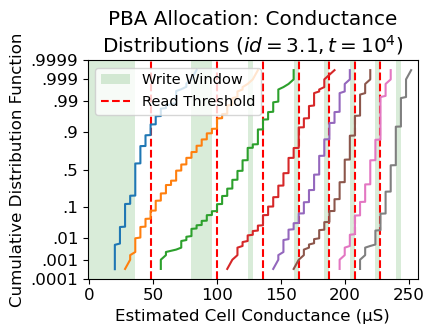

bpc                                                            4
allocation     ((0, 8), (9, 13), (18, 20), (23, 24), (27, 28)...
read_bounds    [0, 9, 13, 18, 24, 27, 31, 35, 38, 41, 44, 47,...
bw                                                 476088.776848
ber                                                     0.114773
cer                                                     0.410856
is_pba                                                      True
bacc                                                    0.885227
Name: 2, dtype: object


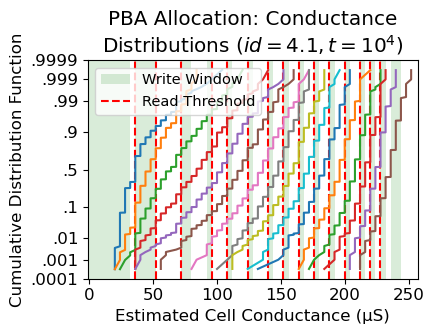

In [9]:
# Visualize chosen allocations
for i, d in best.iterrows():
    if i not in chosen_allocations:
        continue

    plt.figure(figsize=(4.5,3.5))
    plt.xlim(-1, 257)
    plt.ylim(0.0001,0.9999)
    plt.gca().set_yscale("ppf")
    plt.title(f"{'BWA-' if not d['is_pba'] else ''}PBA Allocation: Conductance\nDistributions ($id={chosen_allocations[i]}, t=10^4$)")
    plt.xlabel("Estimated Cell Conductance (µS)")
    plt.ylabel("Cumulative Distribution Function")
    print(d)
    for bounds in d["allocation"]:
        plt.gca().add_patch(patches.Rectangle((bounds[0]*4, 0.0001), bounds[1]*4-bounds[0]*4, 0.9998, linewidth=0, facecolor="green", alpha=0.15, label="Write Window" if bounds[0] == 0 else None))
    for j, bound in enumerate(d["read_bounds"]):
        if bound not in [0,64]:
            plt.axvline(bound*4, color="red", linestyle="--", label="Read Threshold" if j==1 else None)
    for j, lvl in enumerate(d["allocation"]):
        # Get the relevant data
        lvldata = tdata[(tdata["timept"] == timept) & (tdata["lower"] == lvl[0]) & (tdata["upper"] == lvl[1])]

        # Plot distributions
        plt.plot(sorted(lvldata["lvl"].values * 4), np.linspace(0.5/len(lvldata["lvl"].values), 1-0.5/len(lvldata["lvl"].values), len(lvldata["lvl"].values)))#, label=f"Level {j}")
    # if d["is_pba"]:
    #     plt.text(200, 0.5, "PBA", fontsize=12, color="red")
    plt.legend(fontsize=10.5)
    plt.tight_layout()
    plt.savefig(f"figs/alloc_{chosen_allocations[i]}.pdf")
    plt.show()

In [15]:
# Write out configs
with open("../settings/config.json") as config_tmpl_file:
    config_tmpl = json.load(config_tmpl_file)

for i, d in best.iterrows():
    with open(f"../settings/opt/{d['bpc']}bpc_{'bwa' if not d['is_pba'] else 'pba'}_{i}.json", "w") as config_outfile:
        config = deepcopy(config_tmpl)
        config["num_levels"] = len(d["allocation"]) % 16
        config["level_settings"] = config["level_settings"][:len(d["allocation"])]
        config["post_read_setup_cycles"] = 2
        for lvl, ((lower_write, upper_write), read_bound) in enumerate(zip(d["allocation"], d["read_bounds"][1:])):
            config["level_settings"][lvl]["adc_lower_write_ref_lvl"] = lower_write
            config["level_settings"][lvl]["adc_upper_write_ref_lvl"] = upper_write
            config["level_settings"][lvl]["adc_upper_read_ref_lvl"] = min(read_bound, 63)
        json.dump(config, config_outfile, indent=4)